## Table of contents

[1. Exploratory Data Analysis](#EDA) 
- [Imports](#1imports)
- [First Glimps of the Data](#glimps)

[2. Example of Prediction with Openpifpaf](#PifPaf)
- [Imports](#2imports)
- [Constants](#2constants)
- [One image's prediction](#example)

[3. Models Evaluation](#Evaluation)
- [Imports](#3imports)
- [Constants](#3constants)
- [Models Evaluation for Thermal images](#thermal)
- [Model Evaluation for Grey images](#grey)
- [Models Evaluation for Grey images Normalised](#grey_normalised)
- [Comparison Thermal vs Grey vs Grey normalised](#comparison)

## 1. Exploratory Data Analysis <a class = anchor id="EDA"></a>

### Imports <a class = anchor id="1imports"></a>

In [1]:
import matplotlib.pyplot as plt
from notebook_functions import load_folder_csv

### First Glimps of the Data <a class = anchor id="glimps"></a>

In [2]:
data = load_folder_csv('../example_data/movie')
NB_IMAGES = len(data)

23


In [3]:
data[0].shape

(768, 1024)

We plot temperature distribution on each termal image:

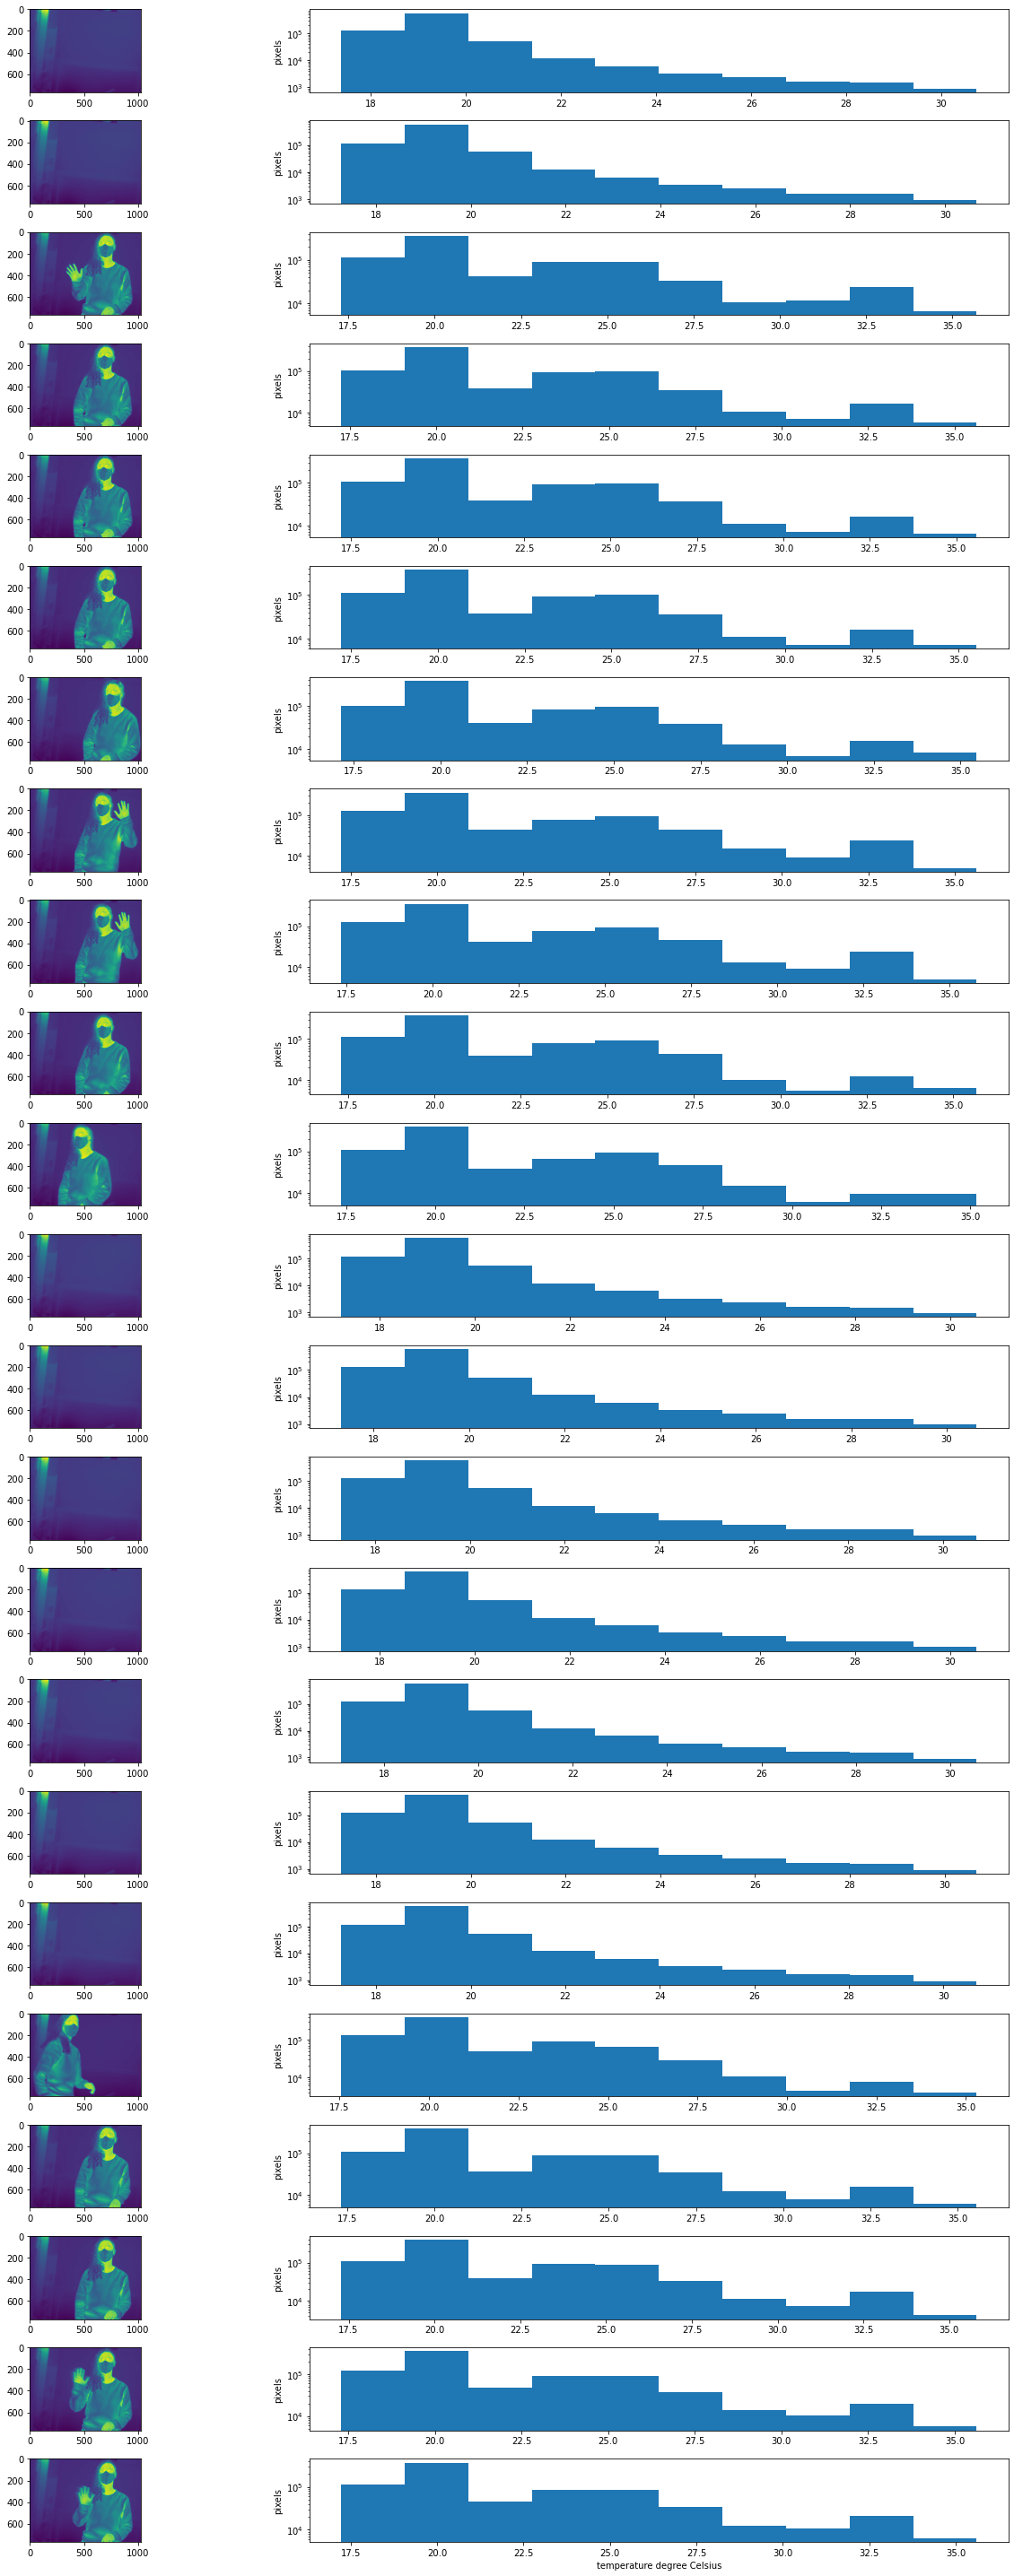

In [4]:
fig = plt.figure(figsize=(20,40))

for i in range(NB_IMAGES):
    ax11 = plt.subplot(NB_IMAGES, 2, 2*i+1)
    plt.imshow(data[i])

    ax12 = plt.subplot(NB_IMAGES, 2, 2*i+2)
    h1 = plt.hist(data[i].flatten(), bins=10)
    ax12.set_yscale('log')
    plt.ylabel("pixels")


plt.xlabel("temperature degree Celsius")

plt.tight_layout()
plt.show()

We can see that a human presence can potentially be deduced from the temperature distribution of the image.
We observe a significantly more important fraction of pixels in the in between 31 and 34 degrees.

We can also note that the proportion of pixel is strictly decreasing with temperature increase from 21 degree when there isn't any human body on the image.

However, potential limitations of this idea are numerous.
What if the human is far away? Then the variation of the temperature distribution might not be notifiable.
What if the surrounding environment already has a temperature similar to the human body, in the 31 to 34 degree Celsius range? Then again we might not notice the presence of the human using the temperature distribution.
The question of being able to count how many human bodies are in the picture also emerges.

To be able to face all these challenges, we will use a pre-trained human-body recognition algorithm, Openpifpaf.

## 2. Example of prediction using Openpifpaf <a class = anchor id="PifPaf"></a>

### Imports <a class = anchor id="2imports"></a>

In [5]:
from files_convertion import *
from pifpaf import get_PifPAf_prediction
from position import *
from notebook_functions import labeled_people, plot_image

### Constants <a class = anchor id="2constants"></a>

In [6]:
body_part_to_index_dictionnary = {"nose": 0, "left-eye": 1, "right-eye": 2, "left-ear": 3,
                        "right-ear": 4, "left-shoulder": 5, "right-shoulder": 6, 
                        "left-elbow": 7, "right-elbow": 8, "left-wrist": 9, 
                        "right-wrist": 10, "navel": 12, "chin": 30,
                        "head-right-bot":26, "head-left-bot":34,
                        "forehead": -1, "right-cheek" : -2, "left-cheek" : -3}

In [7]:
body_part = ['nose', 'right-eye', 'left-eye', 'forehead', 'right-cheek', 'left-cheek', 'right-wrist', 'left-wrist']

### One image prediction <a class = anchor id="example"></a>

We will try on one image to find the position of all our body parts of interest using the shufflenetv2k30-wholebody model. We choose to do it on one image with two peoples to test limits of our algorithm.

In [8]:
image_name = ['FLIR0448']
label =  pd.read_csv('../example_data/examples_labels/'+ image_name[0] + '_label.csv')
label_per_people = labeled_people(label)

#### Thermal RGB Image

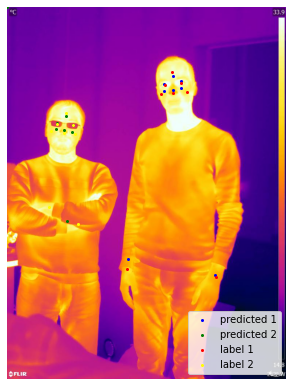

In [9]:
image = get_jpg('../example_data/example_image', image_name)
predictions_df = get_PifPAf_prediction(image, 'shufflenetv2k30-wholebody')
positions = get_body_parts_position(body_part_to_index_dictionnary, body_part, predictions_df)

plot_image(positions, label_per_people, image, body_part)


#### Grayscale Image

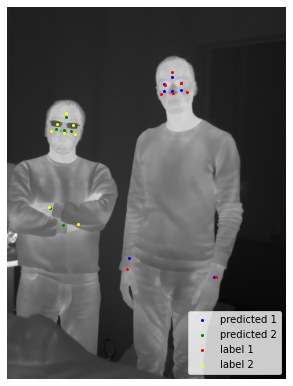

In [10]:
thermal_matrice = get_csv('../example_data/examples_csv/', image_name)
image = transform_thermal_matrices_to_images(thermal_matrice, False)
predictions_df = get_PifPAf_prediction(image, 'shufflenetv2k30')
positions = get_body_parts_position(body_part_to_index_dictionnary, body_part, predictions_df)

plot_image(positions, label_per_people, image, body_part)


#### Normalized Grayscale

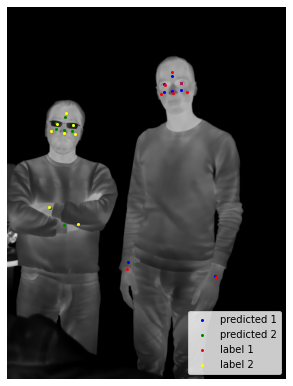

In [11]:
thermal_matrice = get_csv('../example_data/examples_csv/', image_name)
image = transform_thermal_matrices_to_images(thermal_matrice)
predictions_df = get_PifPAf_prediction(image, 'shufflenetv2k30')
positions = get_body_parts_position(body_part_to_index_dictionnary, body_part, predictions_df)

plot_image(positions, label_per_people, image, body_part)


We can see that on this image that for the people at right (blue point), all points of interest are found, but for the one on the left (green point), the left wrist is not found on thermal RGB image.

## 3. Models Evaluation <a class = anchor id="Evaluation"></a>

Openpifpaf algorithm have a lot of models that we could use to detect humans in images. We will now evaluate each of them on our images to be able to choose the more accurate for our task. To evaluate them, we will compute the number of missing point and the euclidian distance between the labeled point and the predicted one.

### Imports <a class = anchor id="3imports"></a>

In [12]:
import pandas as pd
import seaborn as sns
from notebook_functions import evaluation

### Constants <a class = anchor id="3constants"></a>

We choose the pre-trained model adapted for human.

In [13]:
all_models = ['resnet50', 'shufflenetv2k16-wholebody', 'shufflenetv2k16', 'shufflenetv2k16-withdense',
'shufflenetv2k30-wholebody', 'shufflenetv2k30']

In [14]:
color_palette = sns.color_palette("hls", 8)

### Models Evaluation for Thermal images <a class = anchor id="thermal"></a>

We first want to evaluate all the models on the thermal images, which means the jpg files.

In [15]:
image_names = get_files_name('../example_data/examples_images/*.jpg')
images = get_jpg('../example_data/examples_images', image_names)
label = {}
label_names = get_files_name('../example_data/examples_labels/*.csv')
for i in range(len(label_names)):
    label[i] = pd.read_csv('../example_data/examples_labels/'+ label_names[i] + '.csv')
    label[i] = label[i].drop(['Area', 'Mean', 'Min', 'Max'], axis = 1)

In [16]:
percentage_detected, all_euclideans, all_euclideans_weighted, people_detected_per_model, time_per_model = evaluation(all_models,
body_part, images, label, body_part_to_index_dictionnary)

We compute the `time_per_model` taken per model per images.

In [17]:
time_per_model

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
time,4.978716,2.787064,2.285326,2.329808,6.690835,5.980782


For some models and some images, Openpifpaf doesn't found people of interest, these are the `false negative`. Also, sometimes it detects people that are not present in images. We can have for example one detected people of Openpifpaf with all the point except the right wrist and one other detected people of Openpifpaf with jsute the right wrist. These are the `false positive`.

In [18]:
people_detected_per_model

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
false positive,1.0,9.0,0.0,1.0,5.0,1.0
false negative,-2.0,0.0,-1.0,0.0,0.0,0.0
Number total of people,19.0,19.0,19.0,19.0,19.0,19.0


The `percentage_detected` is the number of points for each model that have been detected per body parts over the all number of points that should have been detected. 

In [19]:
percentage_detected

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,94.736842,94.736842,94.736842,94.736842,100.000000,100.000000
right-eye,94.736842,94.736842,94.736842,94.736842,100.000000,100.000000
left-eye,94.736842,94.736842,94.736842,94.736842,100.000000,100.000000
forehead,94.736842,94.736842,94.736842,94.736842,100.000000,100.000000
right-cheek,94.736842,94.736842,94.736842,94.736842,100.000000,100.000000
left-cheek,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
right-wrist,31.578947,42.105263,57.894737,57.894737,78.947368,57.894737
left-wrist,21.052632,10.526316,57.894737,42.105263,73.684211,84.210526


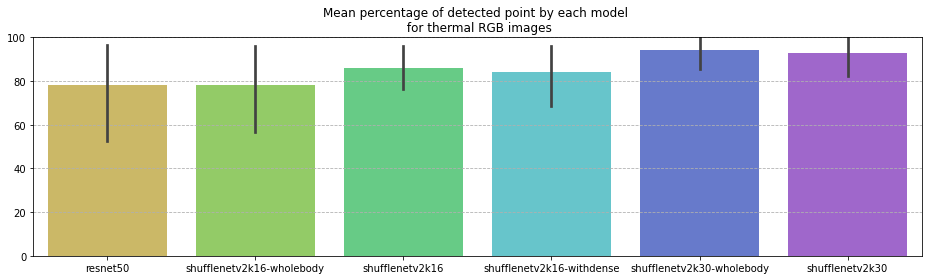

In [20]:
fig = plt.figure(figsize=(13, 4))
ax = sns.barplot(data = percentage_detected, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean percentage of detected point by each model \n for thermal RGB images')
plt.grid(axis = 'y', linestyle = '--')
plt.ylim((0,100))
fig.tight_layout()

The `all_euclideans` variables represents the mean euclideans distance, per model and per body parts, between the point predicted by Openpifpaf and the point that we labeled without taking into account the number of missing point.

In [21]:
all_euclideans

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,8.046465,10.454600,10.086840,7.344084,8.678326,8.642340
right-eye,3.461136,3.843677,4.043202,3.565626,3.737575,3.316430
left-eye,2.276328,3.903343,4.119548,3.387279,3.093887,2.448432
forehead,14.300344,12.534265,13.006706,11.522697,13.068219,14.443274
right-cheek,15.270596,16.095970,15.808921,15.311739,18.932517,19.386047
left-cheek,15.273532,17.712584,17.554465,15.382293,15.478893,16.472154
right-wrist,23.836117,24.610056,24.110246,23.386127,18.436333,15.725716
left-wrist,8.594849,16.511345,10.835464,8.808197,12.693789,9.219053


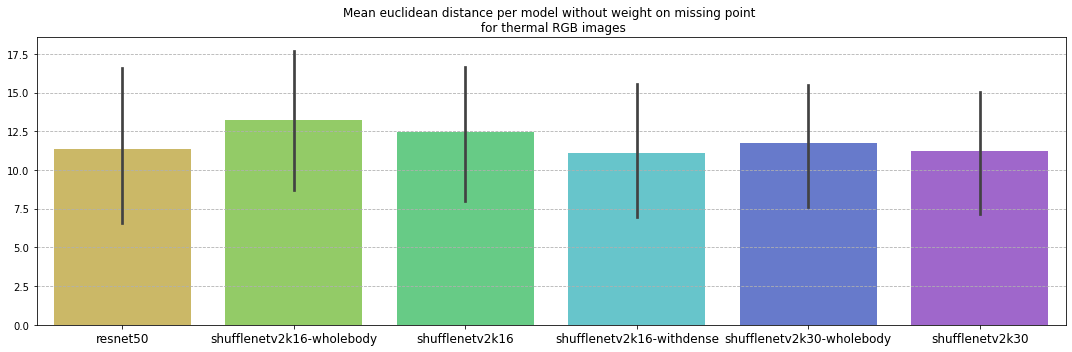

In [22]:
fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(data = all_euclideans, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean euclidean distance per model without weight on missing point \n for thermal RGB images', fontsize = 12)
plt.grid(axis = 'y', linestyle = '--')
plt.xticks(fontsize = 12)
fig.tight_layout()
plt.show()

The `all_euclideans_weighted` represents the mean euclideans distance, per model and per body parts, between the point predicted by Openpifpaf and the point that we labeled taking into account the number of missing point. 

In [23]:
all_euclideans_weighted

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,19.984908,21.009621,21.248682,18.062817,8.678326,8.642340
right-eye,13.286951,12.615062,13.290802,12.351646,3.737575,3.316430
left-eye,11.407132,11.987378,12.640684,11.498475,3.093887,2.448432
forehead,19.900324,17.637725,18.367445,16.679397,13.068219,14.443274
right-cheek,25.166444,24.906709,25.125092,24.163752,18.932517,19.386047
left-cheek,15.273532,17.712584,17.554465,15.382293,15.478893,16.472154
right-wrist,184.637910,151.721760,116.579748,115.521758,57.730421,101.227151
left-wrist,170.668041,176.045089,93.667869,125.296451,63.976160,39.614308


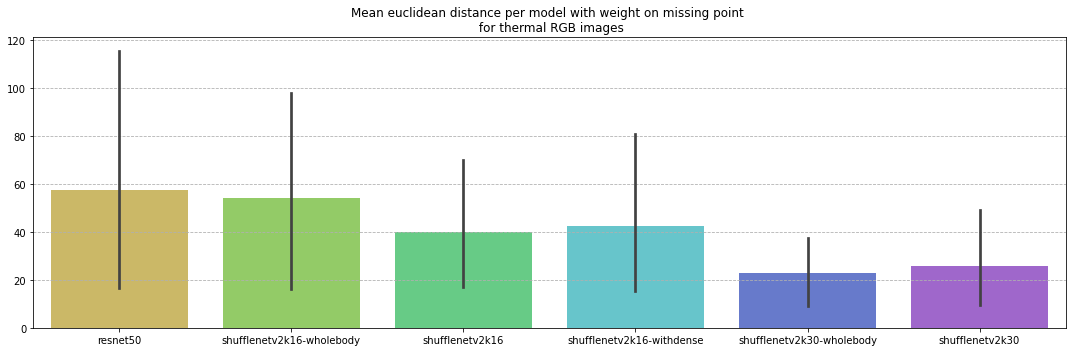

In [24]:
fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(data = all_euclideans_weighted, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean euclidean distance per model with weight on missing point \n for thermal RGB images')
plt.grid(axis = 'y', linestyle = '--')
fig.tight_layout()
plt.show()

### Models Evaluation for Grey images <a class = anchor id="grey"></a>

In [25]:
image_names = get_files_name('../example_data/examples_csv/*.csv')
thermal_matrices = get_csv('../example_data/examples_csv/', image_names)
images_grey = transform_thermal_matrices_to_images(thermal_matrices, False)
label_grey = {}
label_names_grey = get_files_name('../example_data/examples_labels/*.csv')
for i in range(len(label_names_grey)):
    label_grey[i] = pd.read_csv('../example_data/examples_labels/'+ label_names_grey[i] + '.csv')
    label_grey[i] = label_grey[i].drop(['Area', 'Mean', 'Min', 'Max'], axis = 1)

In [26]:
percentage_detected_grey, all_euclideans_grey, all_euclideans_weighted_grey, people_detected_per_model_grey, time_per_model_grey = evaluation(all_models,
body_part, images_grey, label_grey, body_part_to_index_dictionnary)

In [27]:
time_per_model_grey

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
time,5.940236,3.21641,2.548787,2.636015,6.920235,6.249231


In [28]:
people_detected_per_model_grey

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
false positive,1.0,17.0,1.0,0.0,3.0,0.0
false negative,-3.0,0.0,-1.0,0.0,0.0,0.0
Number total of people,19.0,19.0,19.0,19.0,19.0,19.0


In [29]:
percentage_detected_grey

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,89.473684,100.000000,89.473684,94.736842,100.000000,100.000000
right-eye,100.000000,100.000000,94.736842,94.736842,100.000000,100.000000
left-eye,100.000000,100.000000,94.736842,94.736842,100.000000,100.000000
forehead,100.000000,100.000000,94.736842,94.736842,100.000000,100.000000
right-cheek,89.473684,100.000000,89.473684,94.736842,100.000000,100.000000
left-cheek,89.473684,100.000000,94.736842,100.000000,100.000000,100.000000
right-wrist,31.578947,47.368421,57.894737,52.631579,68.421053,73.684211
left-wrist,26.315789,15.789474,31.578947,42.105263,73.684211,89.473684


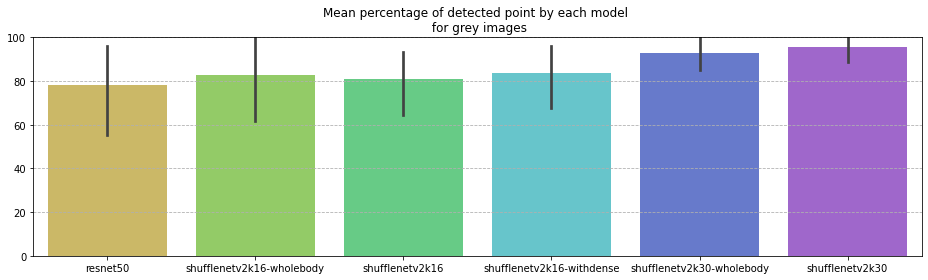

In [30]:
fig = plt.figure(figsize=(13, 4))
ax = sns.barplot(data = percentage_detected_grey, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean percentage of detected point by each model \n for grey images')
plt.grid(axis = 'y', linestyle = '--')
plt.ylim((0,100))
fig.tight_layout()

In [31]:
all_euclideans_grey

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,7.439584,9.919660,8.693826,6.936174,7.951584,8.167887
right-eye,3.314820,4.273986,3.829741,3.656727,3.669065,3.584582
left-eye,1.994607,3.039255,3.352438,2.909176,2.886809,1.979163
forehead,22.844325,14.889827,17.858622,12.628238,12.945174,14.668994
right-cheek,13.938588,19.070037,15.571276,14.756785,18.970639,19.146096
left-cheek,15.955221,17.570171,15.283459,16.244230,15.048839,16.286384
right-wrist,10.774116,31.500867,28.304855,28.012815,15.301491,19.784076
left-wrist,28.004067,18.312901,7.124090,8.969061,12.302404,10.586316


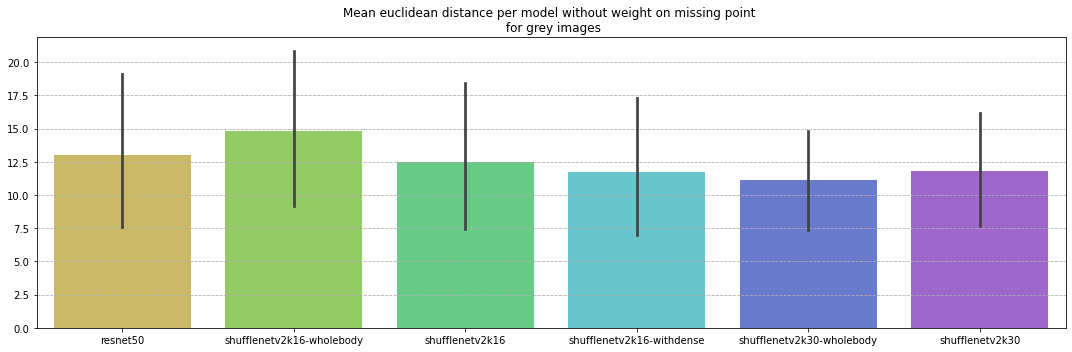

In [32]:
fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(data = all_euclideans_grey, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean euclidean distance per model without weight on missing point \n for grey images')
plt.grid(axis = 'y', linestyle = '--')
fig.tight_layout()
plt.show()

In [33]:
all_euclideans_weighted_grey

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,27.822136,9.919660,29.505623,17.676375,7.951584,8.167887
right-eye,3.314820,4.273986,13.089199,12.437952,3.669065,3.584582
left-eye,1.994607,3.039255,11.916192,11.045536,2.886809,1.979163
forehead,22.844325,14.889827,22.949810,17.726752,12.945174,14.668994
right-cheek,33.758764,19.070037,33.970745,23.638007,18.970639,19.146096
left-cheek,35.065006,17.570171,24.888100,16.244230,15.048839,16.286384
right-wrist,184.197209,134.903884,115.076697,131.436534,77.872915,73.954898
left-wrist,160.333883,163.558195,136.932636,127.837868,61.424613,32.928125


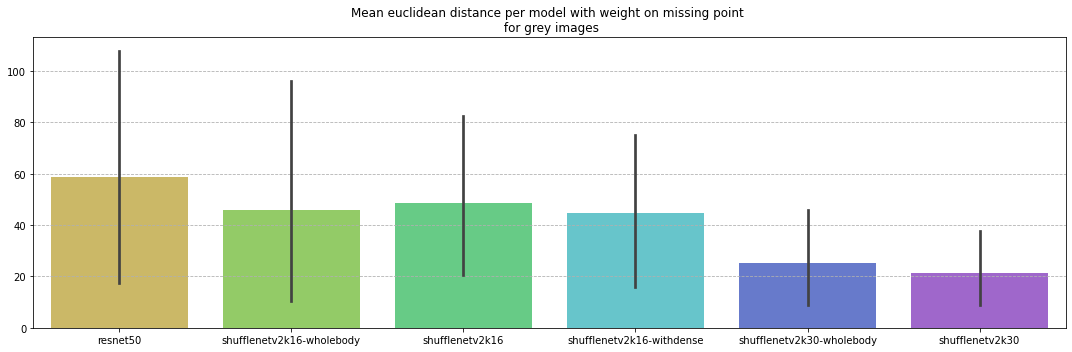

In [34]:
fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(data = all_euclideans_weighted_grey, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean euclidean distance per model with weight on missing point \n for grey images')
plt.grid(axis = 'y', linestyle = '--')
fig.tight_layout()
plt.show()

### Models Evaluation for Grey images Normalised <a class = anchor id="grey_normalised"></a>

In [35]:
image_names_grey_n = get_files_name('../example_data/examples_csv/*.csv')
thermal_matrices_n = get_csv('../example_data/examples_csv/', image_names_grey_n)
images_grey_n = transform_thermal_matrices_to_images(thermal_matrices_n)
label_grey_n = {}
label_names_grey_n = get_files_name('../example_data/examples_labels/*.csv')
for i in range(len(label_names_grey_n)):
    label_grey_n[i] = pd.read_csv('../example_data/examples_labels/'+ label_names_grey_n[i] + '.csv')
    label_grey_n[i] = label_grey_n[i].drop(['Area', 'Mean', 'Min', 'Max'], axis = 1)

In [36]:
percentage_detected_grey_n, all_euclideans_grey_n, all_euclideans_weighted_grey_n, people_detected_per_model_grey_n,\
 time_per_model_grey_n = evaluation(all_models, body_part, images_grey_n, label_grey_n, body_part_to_index_dictionnary)

In [37]:
time_per_model_grey_n

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
time,5.023878,2.759262,2.285775,2.330275,6.664494,5.922851


In [38]:
people_detected_per_model_grey_n

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
false positive,0.0,16.0,2.0,3.0,3.0,0.0
false negative,-3.0,0.0,-1.0,0.0,0.0,0.0
Number total of people,19.0,19.0,19.0,19.0,19.0,19.0


In [39]:
percentage_detected_grey_n

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,94.736842,94.736842,89.473684,94.736842,100.000000,100.000000
right-eye,100.000000,94.736842,94.736842,94.736842,100.000000,100.000000
left-eye,100.000000,94.736842,94.736842,94.736842,100.000000,100.000000
forehead,100.000000,94.736842,94.736842,94.736842,100.000000,100.000000
right-cheek,94.736842,94.736842,89.473684,94.736842,100.000000,100.000000
left-cheek,94.736842,100.000000,94.736842,100.000000,100.000000,100.000000
right-wrist,31.578947,47.368421,57.894737,42.105263,63.157895,68.421053
left-wrist,26.315789,15.789474,36.842105,36.842105,68.421053,89.473684


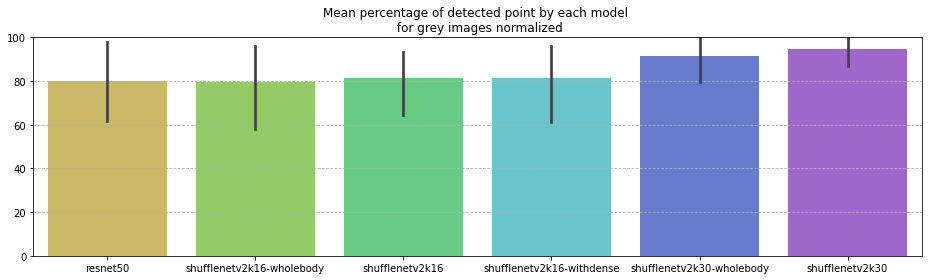

In [40]:
fig = plt.figure(figsize=(13, 4))
ax = sns.barplot(data = percentage_detected_grey_n, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean percentage of detected point by each model \n for grey images normalized')
plt.grid(axis = 'y', linestyle = '--')
plt.ylim((0,100))
fig.tight_layout()

In [41]:
all_euclideans_grey_n

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,7.304895,9.351726,8.762562,7.205766,8.406878,8.201476
right-eye,3.228244,3.475709,3.535354,3.518329,4.279328,3.954779
left-eye,1.802690,3.717074,3.043629,3.563874,2.765096,1.861017
forehead,19.352947,12.486440,18.087728,13.109235,13.191092,14.485834
right-cheek,13.773823,15.937446,15.090384,13.961050,18.468942,18.484456
left-cheek,15.973110,17.204781,14.898655,16.281814,15.285847,16.131079
right-wrist,10.644236,33.262111,30.744924,30.331450,18.410516,18.070315
left-wrist,30.725814,25.860250,6.424071,10.257888,10.460394,10.877575


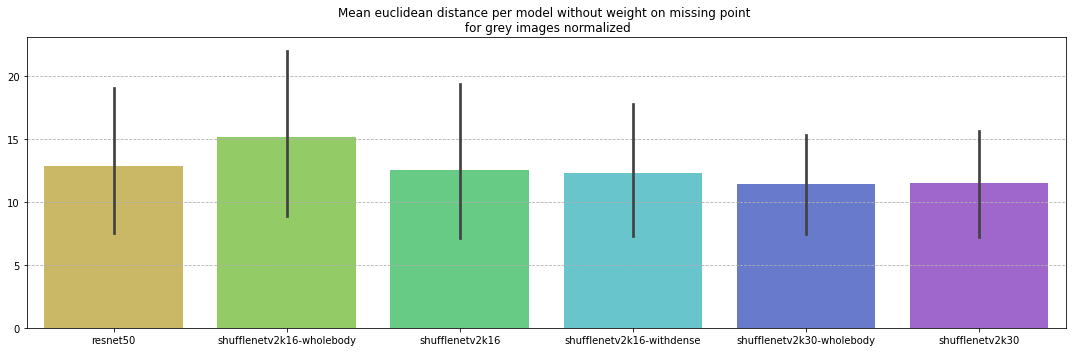

In [42]:
fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(data = all_euclideans_grey_n, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean euclidean distance per model without weight on missing point \n for grey images normalized')
plt.grid(axis = 'y', linestyle = '--')
fig.tight_layout()
plt.show()

In [43]:
all_euclideans_weighted_grey_n

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
nose,18.160839,19.964793,29.566722,17.931779,8.406878,8.201476
right-eye,3.228244,12.266461,12.811168,12.306838,4.279328,3.954779
left-eye,1.802690,11.810912,11.624538,11.665775,2.765096,1.861017
forehead,19.352947,17.592417,23.166187,18.182434,13.191092,14.485834
right-cheek,24.090021,24.756528,33.543286,22.884153,18.468942,18.484456
left-cheek,26.735228,17.204781,24.524674,16.281814,15.285847,16.131079
right-wrist,184.172857,135.738158,114.617514,153.007926,96.653958,80.820005
left-wrist,160.674102,164.749882,124.493246,135.691538,67.911533,33.188725


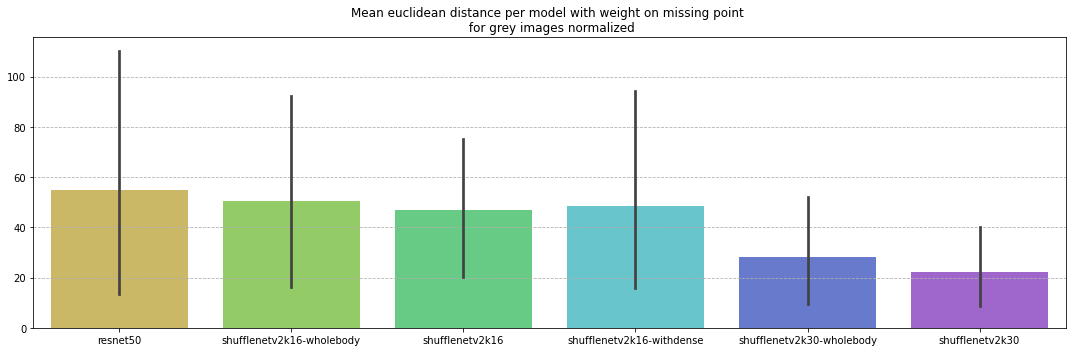

In [44]:
fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(data = all_euclideans_weighted_grey_n, palette = [color_palette[1],color_palette[2], color_palette[3],
color_palette[4], color_palette[5], color_palette[6]])
plt.title('Mean euclidean distance per model with weight on missing point \n for grey images normalized')
plt.grid(axis = 'y', linestyle = '--')
fig.tight_layout()
plt.show()

### Comparison Thermal vs Grey vs Grey normalised <a class = anchor id="comparison"></a>

To compare the results of Openpifpaf on Thermal images versus on Grey Images, we use the best models for each one. This means that we will use the ... one for Thermal images and the .... model for Grey images.

In [45]:
comparison_percentage = pd.concat([percentage_detected['shufflenetv2k30-wholebody'], percentage_detected_grey['shufflenetv2k30']], axis = 1)
comparison_percentage = comparison_percentage.rename(columns={'shufflenetv2k30-wholebody' : 'Thermal RGB', 'shufflenetv2k30' : 'Grey'})
comparison_2_percentage = pd.concat([comparison_percentage, percentage_detected_grey_n['shufflenetv2k30']], axis =1)
comparison_2_percentage = comparison_2_percentage.rename(columns = {'shufflenetv2k30' : 'Grey Normalized'})

comparison_2_percentage

,Thermal RGB,Grey,Grey Normalized
nose,100.000000,100.000000,100.000000
right-eye,100.000000,100.000000,100.000000
left-eye,100.000000,100.000000,100.000000
forehead,100.000000,100.000000,100.000000
right-cheek,100.000000,100.000000,100.000000
left-cheek,100.000000,100.000000,100.000000
right-wrist,78.947368,73.684211,68.421053
left-wrist,73.684211,89.473684,89.473684


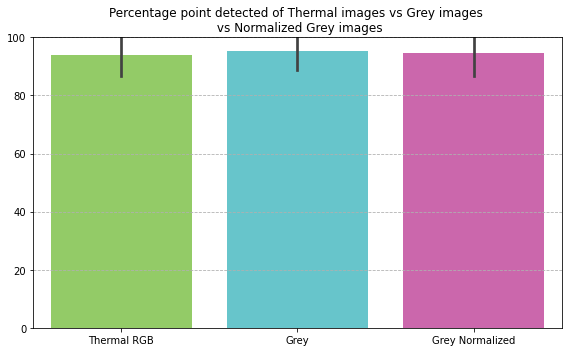

In [46]:
fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(data = comparison_2_percentage, palette = [color_palette[2],color_palette[4], color_palette[7]])
plt.title('Percentage point detected of Thermal images vs Grey images \n vs Normalized Grey images')
plt.grid(axis = 'y', linestyle = '--')
fig.tight_layout()
plt.ylim((0,100))
plt.show()

In [47]:
comparison_without_weight = pd.concat([all_euclideans['shufflenetv2k30-wholebody'], all_euclideans_grey['shufflenetv2k30']], axis = 1)
comparison_without_weight = comparison_without_weight.rename(columns={'shufflenetv2k30-wholebody' : 'Thermal RGB', 'shufflenetv2k30' : 'Grey'})
comparison_2_withtout_weight = pd.concat([comparison_without_weight, all_euclideans_grey_n['shufflenetv2k30']], axis =1)
comparison_2_withtout_weight = comparison_2_withtout_weight.rename(columns = {'shufflenetv2k30' : 'Grey Normalized'})

comparison_2_withtout_weight

,Thermal RGB,Grey,Grey Normalized
nose,8.678326,8.167887,8.201476
right-eye,3.737575,3.584582,3.954779
left-eye,3.093887,1.979163,1.861017
forehead,13.068219,14.668994,14.485834
right-cheek,18.932517,19.146096,18.484456
left-cheek,15.478893,16.286384,16.131079
right-wrist,18.436333,19.784076,18.070315
left-wrist,12.693789,10.586316,10.877575


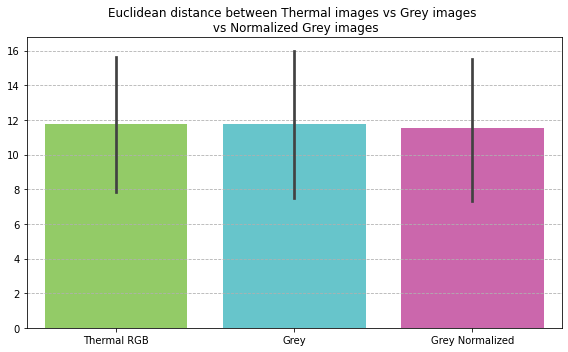

In [48]:
fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(data = comparison_2_withtout_weight, palette = [color_palette[2],color_palette[4], color_palette[7]])
plt.title('Euclidean distance between Thermal images vs Grey images \n vs Normalized Grey images')
plt.grid(axis = 'y', linestyle = '--')
fig.tight_layout()
plt.show()

In [49]:
comparison = pd.concat([all_euclideans_weighted['shufflenetv2k30-wholebody'], all_euclideans_weighted_grey['shufflenetv2k30']], axis = 1)
comparison = comparison.rename(columns={'shufflenetv2k30-wholebody' : 'Thermal RGB', 'shufflenetv2k30' : 'Grey'})
comparison_2 = pd.concat([comparison,all_euclideans_weighted_grey_n['shufflenetv2k30']], axis =1)
comparison_2 = comparison_2.rename(columns = {'shufflenetv2k30' : 'Grey Normalized'})
    
comparison_2

,Thermal RGB,Grey,Grey Normalized
nose,8.678326,8.167887,8.201476
right-eye,3.737575,3.584582,3.954779
left-eye,3.093887,1.979163,1.861017
forehead,13.068219,14.668994,14.485834
right-cheek,18.932517,19.146096,18.484456
left-cheek,15.478893,16.286384,16.131079
right-wrist,57.730421,73.954898,80.820005
left-wrist,63.976160,32.928125,33.188725


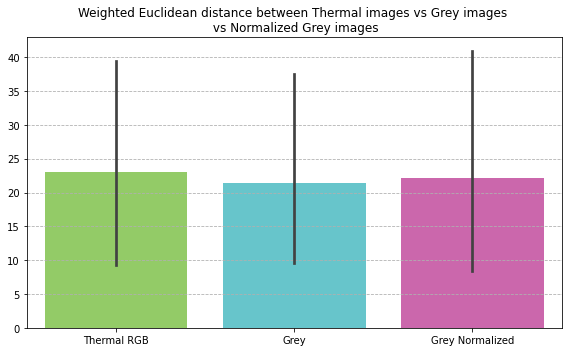

In [50]:
fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(data = comparison_2, palette = [color_palette[2],color_palette[4], color_palette[7]])
plt.title('Weighted Euclidean distance between Thermal images vs Grey images \n vs Normalized Grey images')
plt.grid(axis = 'y', linestyle = '--')
fig.tight_layout()
plt.show()


We also compute the time per model per images

In [51]:
test = pd.concat([time_per_model,time_per_model_grey], axis = 0)
all_time = pd.concat([test, time_per_model_grey_n], axis = 0)
all_time.index = ['Thermal RGB', 'Gray Scale', 'Normalised gray scale']
all_time

,resnet50,shufflenetv2k16-wholebody,shufflenetv2k16,shufflenetv2k16-withdense,shufflenetv2k30-wholebody,shufflenetv2k30
Thermal RGB,4.978716,2.787064,2.285326,2.329808,6.690835,5.980782
Gray Scale,5.940236,3.216410,2.548787,2.636015,6.920235,6.249231
Normalised gray scale,5.023878,2.759262,2.285775,2.330275,6.664494,5.922851


We can see that the Normalised grey scale is the fastest.

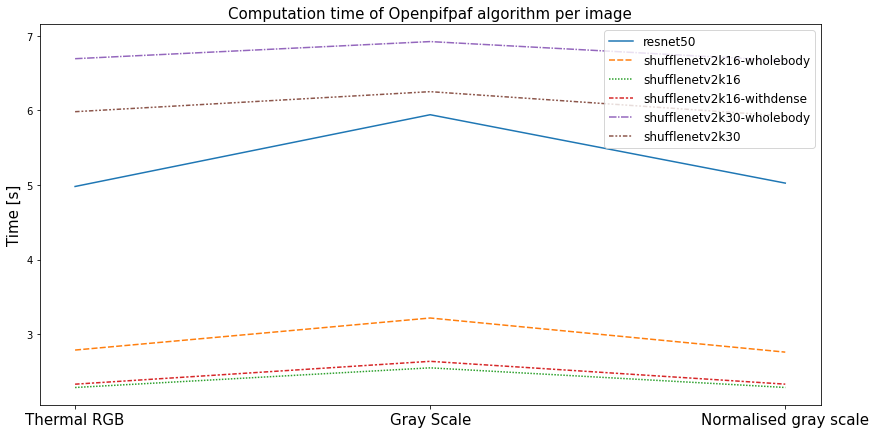

In [52]:
fig = plt.figure(figsize=(14,7))
ax = sns.lineplot( data = all_time)
plt.title('Computation time of Openpifpaf algorithm per image', fontsize = 15)
plt.ylabel('Time [s]', fontsize = 15)
plt.legend(loc = "upper right", fontsize = 12)
plt.xticks(fontsize = 15)
plt.show()
